# ACML Assignment 2
# Ziyaad Ballim (1828251)

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from prettytable import PrettyTable
import seaborn as sns
sns.set()

# Reading in the data

##### This dataset has been collected from patients tested for diabetes. There are 8 features namely: 

-Pregnancies 

-Glucose

-BloodPressure

-SkinThickness

-Insulin

-BMI

-DiabetesPedigreeFunction

-Age

 and one output column "Ouput" which represents the presence of diabetes or not with 1 or 0 respectively.

In [2]:
data = pd.read_csv('diabetes-dataset.csv')

In [3]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.703500,121.182500,69.145500,20.935000,80.254000,32.193000,0.470930,33.090500,0.342000
std,3.306063,32.068636,19.188315,16.103243,111.180534,8.149901,0.323553,11.786423,0.474498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.375000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.376000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.800000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000,1.000000


In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


##### Checking for null values

In [5]:
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## Functions for splitting and standardizing the data

##### Splitting data into training, validation and testing subsets

In [6]:
def SplitData(x,y,testSize):
        trainx,testx, trainy,testy = train_test_split(x,y,test_size=testSize,random_state=40)
        return trainx,trainy,testx,testy

##### Standardizing the data

In [7]:
def StandardizeData(data):
    rows,cols = np.shape(data)
    
    for i in range(cols):
        Feature = data[:,i]
        mean = np.mean(Feature)
        standard_deviation = np.std(Feature)
        Feature -= mean
        Feature /= standard_deviation
        data[:,i] = Feature
    
    return data

##### Scaling

In [8]:
def ScaleData(data):
        scaledx  = StandardizeData(data)
        return scaledx

In [9]:
def Split_Data(data,validation_and_test_size,scale):
        arrData = data.to_numpy()
        np.random.shuffle(arrData)

        rows,cols = np.shape(arrData)
        Features = arrData[:,:cols-1]
        Target = arrData[:, -1]
        Target = np.reshape(Target,(np.shape(Target)[0],1))
        if(scale):
            Features = ScaleData(Features)
        test_size = np.round(validation_and_test_size*0.3,2)
        trainx,trainy,tempx,tempy =SplitData(Features,Target,validation_and_test_size)
        validationx,validationy,testx,testy =SplitData(tempx,tempy,test_size)
        return trainx,validationx,testx, trainy,validationy,testy

## Splitting and standardizing the data

In [10]:
trainx,validationx,testx,trainy,validationy,testy = Split_Data(data,0.3,True)

In [11]:
print(len(trainx))
print(len(validationx))
print(len(testx))
print(len(trainy))
print(len(validationy))
print(len(testy))

1400
546
54
1400
546
54


## The functions below are used to construct, train and test the intended Neural Networks

#### Initialising the weights of the neural network between 0 and 1

In [12]:
def InitWeights(NumFeatures,NumHidLayers,NumNeurons,NumOutputNeurons):
        InLayerWeights = np.random.rand(NumNeurons[0],NumFeatures+1)
        Weights  = [InLayerWeights]
        for i in range(NumHidLayers):
            W = None
            if(NumHidLayers -1 == i):
                W = np.random.rand(NumOutputNeurons,NumNeurons[i]+1)

            else:
                W = np.random.rand(NumNeurons[i+1],NumNeurons[i]+1)

            Weights.append(W)

        return Weights

#### Converting the output probabilities to output classes



In [13]:
def ProbToClass(LatestActivation):
    Indices = np.where(LatestActivation<0.5)
    LatestActivation[Indices] = 0
    Indices2 = np.where(LatestActivation>=0.5)
    LatestActivation[Indices2] = 1
    return LatestActivation

#### Controling the use of the different activation functions

In [14]:
def ActFunction(Z,Activation):
    a = None
    deriv_z = None
    if (Activation == "sigmoid"):
        a = (1/(1+np.exp(-Z)))
        deriv_z = a * (1-a)
    elif (Activation == "tanh"):
        a =  np.tanh(Z)
        deriv_z = 1 - (a**2)
    elif (Activation == "relu"):
        a =  np.maximum(0,Z)
        deriv_z = np.copy(a)
        deriv_z[deriv_z<=0] = 0
        deriv_z[deriv_z>0] = 1
    return a,deriv_z

#### Forward propogation in order to obtain predicted outputs

In [15]:
def ForwardProp(features,weights,activations):
    A_Vals = [features]
    Derivs = [0]
    n = len(weights)
    for i in range(n):
        z  = None
        aprev = np.insert(A_Vals[i],0,1,axis=1)
        z = np.dot(weights[i],aprev.T)
        A_Vals[i] = aprev
        a,derivative_of_z = ActFunction(z,activations[i])
        A_Vals.append(a.T)
        Derivs.append(derivative_of_z)

    return A_Vals,Derivs

#### Computing the errors

In [16]:
def Errors(a,y,Weights,derivs):
    n = len(a)
    errors = [a[n-1]-y]
    loopLength = n -2
    for j in range(loopLength):
        e = (((Weights[loopLength - j].T)[1:,:])@(errors[j].T))* derivs[loopLength - j]
        errors.append(e.T)

    return errors

#### Obtaining gradients

In [17]:
def Grads(Errors,Activations):
    grads = []
    reversed_errors = list(reversed(Errors))
    n  = len(Activations)
    for i in range(n-1):
        g = (reversed_errors[i].T)@(Activations[i])
        grads.append(g)
    return grads

#### Performing back propogations

In [18]:
def BackProp(Features,Target,Weights,Activations,numDataPoints,regularization,gradients):
    avalues,derivatives = ForwardProp(Features,Weights,Activations)

    errors = Errors(avalues,Target,Weights,derivatives)

    Updatedgradients = Grads(errors,avalues)
    for k in range(len(gradients)):
            gradients[k]+=Updatedgradients[k]

    if(regularization != 0):
        n = len(gradients)
        for i in range(n):
            gradients[i] = (1/numDataPoints)*gradients[i] + regularization*Weights[i]
    else:
        n = len(gradients)
        for i in range(n):
            gradients[i] = (1/numDataPoints)*gradients[i]

    return gradients

#### Checking for the convergence of the weights

In [19]:
def WeightConv(NewWeights,OldWeights):
    n = len(NewWeights)
    Controls = []
    for k in range(n):
        if(np.linalg.norm(NewWeights[k]-OldWeights[k])<0.00005):
            Controls.append(True)
        else:
            Controls.append(False)

    numFalse = np.where(np.asarray(Controls)==False)
    length = len(numFalse[0])
    if(length>1):
        return False
    else:
        return True

#### Dealing with division errors

In [20]:
def DivError(x):
    ETA = 0.0000000001
    return np.maximum(x, ETA)

#### Calculating the costs

In [21]:
def Cost(Target,predicted,regularization,weights):
    n = len(Target)
    yhat_inv = np.subtract(1.0,predicted)
    y_inv = np.subtract(1.0,Target)
    yhat = DivError(predicted) 
    yhat_inv = DivError(yhat_inv)
    weightsSummation=0;
    for w in weights:
        weightsSummation+= np.sum(w**2)
    loss = -1/n * (np.sum(np.multiply(np.log(yhat), Target) + np.multiply((y_inv), np.log(yhat_inv))))+ (regularization/(2*n))*weightsSummation
    return loss

#### Performing gradient descent

In [22]:
def GradDescent(Features,Target,weights,numDataPoints,learningRate,regularization,Epochs,ActivationFunctions):
    gradients = [None]*len(weights)
    loss = []
    for i in range(len(gradients)):
        gradients[i] = np.zeros(np.shape(weights[i]))

    iterations=0
    control = True
    while iterations<Epochs and control:
        Old_Weights = weights.copy()
        D = BackProp(Features,Target,weights,ActivationFunctions,numDataPoints,regularization,gradients)


        for j in range(len(D)):
            weights[j] = weights[j]- learningRate*D[j]

        if(WeightConv(weights,Old_Weights)):
            control = False
        iterations+=1
        a,v = ForwardProp(Features,weights,ActivationFunctions)
        predictedValues = a[len(a)-1]
        lossValue = Cost(Target,predictedValues,regularization,weights)
        loss.append(lossValue)
    return weights,iterations,loss

#### Finding the output predictions

In [23]:
def Predict(testx,testy,weights,ActivationFunctions):
    act,der = ForwardProp(testx,weights,ActivationFunctions)
    act[len(act)-1] = ProbToClass(act[len(act)-1])
    predictedValues = act[len(act)-1]
    conf = confusion_matrix(testy,predictedValues)
    acc = accuracy_score(testy,predictedValues)
    print(f'The accuracy is: {acc*100}%')
    print("Confusion Matrix: ")
    sns.heatmap(conf,annot=True,fmt='g')
    plt.show()
    return acc

#### Plotting the error graph over time

In [24]:
def ErrorGraph(error):
    x = np.arange(1,(len(error)+1))
    sns.lineplot(x = x ,y = error)
    plt.title("Error vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.show()

#### Fitting the neural network using the above functions and getting the neccessary input

In [25]:
def FitNN(TrainingX,TrainingY,NumberOfHiddenLayers,NumberOfNeuronsPerHiddenLayer,NumberOfNeuronsInOutputLayer,ActivationFunctions,learningRate,regularization,Epochs):
    Number_of_datapoints, Number_of_features = np.shape(TrainingX)

    Weight_Parameters = InitWeights(Number_of_features,NumberOfHiddenLayers,NumberOfNeuronsPerHiddenLayer,NumberOfNeuronsInOutputLayer) 
    assert(len(ActivationFunctions) == NumberOfHiddenLayers+NumberOfNeuronsInOutputLayer), "Please ensure that the number of activation functions specified is the same as the layers!"
    Weights,epochs_to_converge,error = GradDescent(TrainingX,TrainingY,Weight_Parameters,Number_of_datapoints,learningRate,regularization,Epochs,ActivationFunctions)
    ErrorGraph(error)
    weights = Weights
    activationFunctions = ActivationFunctions
    return Weights,epochs_to_converge,error, activationFunctions

## Implementation of Neural network and training the network using back-propogation

### Relu Activation Function

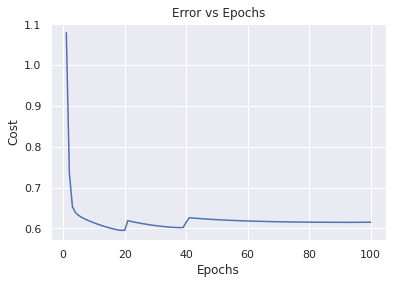

Number of epochs until convergence:100

Training Accuracy
The accuracy is: 72.64285714285714%
Confusion Matrix: 


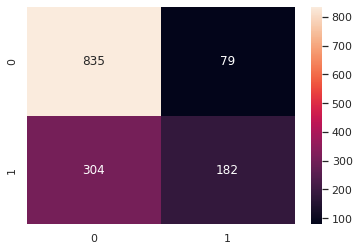

Validation Accuracy
The accuracy is: 74.54212454212454%
Confusion Matrix: 


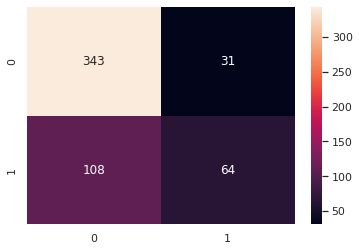

Test Accuracy
The accuracy is: 70.37037037037037%
Confusion Matrix: 


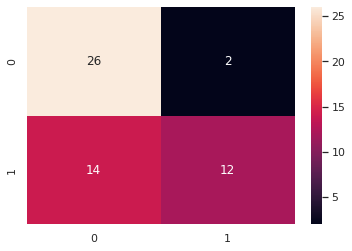

In [26]:
ReluWeights, ReluEpochs, ReluError, ReluActivations = FitNN(trainx,trainy,2,[2,2],1,["relu","relu","relu"],0.1,0,100)
print("Number of epochs until convergence:"+str(ReluEpochs)+"\n")
print("Training Accuracy")
Relu_Acc=Predict(trainx,trainy,ReluWeights,ReluActivations)
print("Validation Accuracy")
Relu_Acc_Val=Predict(validationx,validationy,ReluWeights,ReluActivations)
print("Test Accuracy")
Relu_Acc_Test=Predict(testx,testy,ReluWeights,ReluActivations)

### Sigmoid Activation Function

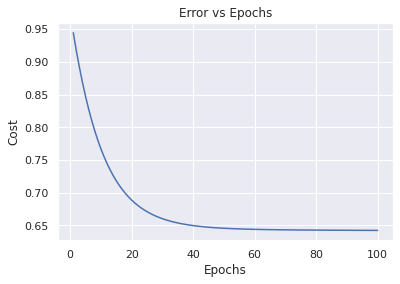

Number of epochs until convergence:100

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


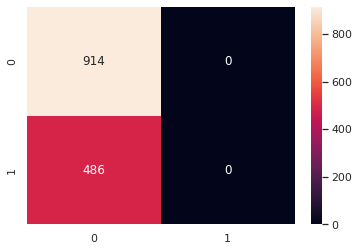

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


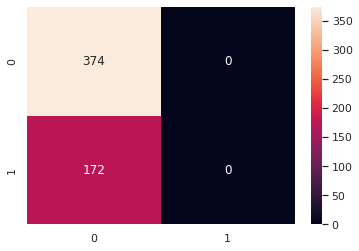

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


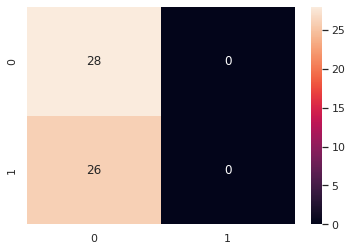

In [27]:
SigWeights, SigEpochs, SigError, SigActivations = FitNN(trainx,trainy,2,[2,2],1,["sigmoid","sigmoid","sigmoid"],0.1,0,100)
print("Number of epochs until convergence:"+str(SigEpochs)+"\n")
print("Training Accuracy")
Sig_Acc=Predict(trainx,trainy,SigWeights,SigActivations)
print("Validation Accuracy")
Sig_Acc_Val=Predict(validationx,validationy,SigWeights,SigActivations)
print("Test Accuracy")
Sig_Acc_Test=Predict(testx,testy,SigWeights,SigActivations)

### Tanh Activation Function

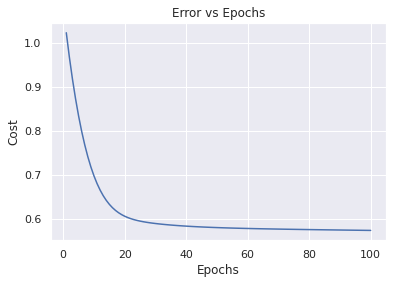

Number of epochs until convergence:100

Training Accuracy
The accuracy is: 69.35714285714286%
Confusion Matrix: 


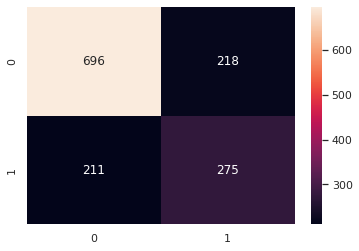

Validation Accuracy
The accuracy is: 71.97802197802197%
Confusion Matrix: 


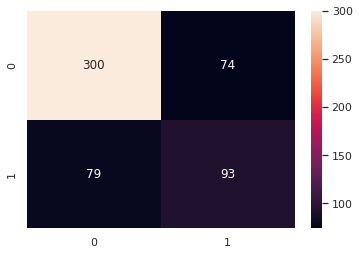

Test Accuracy
The accuracy is: 68.51851851851852%
Confusion Matrix: 


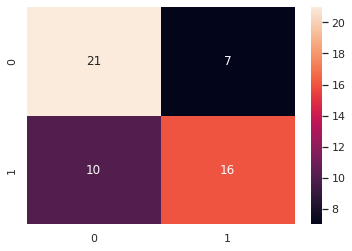

In [28]:
TanhWeights, TanhEpochs, TanhError, TanhActivations = FitNN(trainx,trainy,2,[2,2],1,["tanh","tanh","tanh"],0.1,0,100)
print("Number of epochs until convergence:"+str(TanhEpochs)+"\n")
print("Training Accuracy")
Tanh_Acc=Predict(trainx,trainy,TanhWeights,TanhActivations)
print("Validation Accuracy")
Tanh_Acc_Val=Predict(validationx,validationy,TanhWeights,TanhActivations)
print("Test Accuracy")
Tanh_Acc_Test=Predict(testx,testy,TanhWeights,TanhActivations)

In [29]:
InitialResults = PrettyTable(["Activation Function","Epochs to train","Training Accuracy","Validation Accuracy","Testing Accuracy"])

InitialResults.add_row(["ReLu",ReluEpochs,np.round(Relu_Acc*100,2),np.round(Relu_Acc_Val*100,2),np.round(Relu_Acc_Test*100,2)])
InitialResults.add_row(["Sigmoid",SigEpochs,np.round(Sig_Acc*100,2),np.round(Sig_Acc_Val*100,2),np.round(Sig_Acc_Test*100,2)])
InitialResults.add_row(["Tanh",TanhEpochs,np.round(Tanh_Acc*100,2),np.round(Tanh_Acc_Val*100,2),np.round(Tanh_Acc_Test*100,2)])
print(InitialResults)

+---------------------+-----------------+-------------------+---------------------+------------------+
| Activation Function | Epochs to train | Training Accuracy | Validation Accuracy | Testing Accuracy |
+---------------------+-----------------+-------------------+---------------------+------------------+
|         ReLu        |       100       |       72.64       |        74.54        |      70.37       |
|       Sigmoid       |       100       |       65.29       |         68.5        |      51.85       |
|         Tanh        |       100       |       69.36       |        71.98        |      68.52       |
+---------------------+-----------------+-------------------+---------------------+------------------+


## Testing different network sizes(Number of hidden layers and number of neurons)

### Relu

### 1 Hidden Layers vs 2 Hidden Layers

#### 8 Neurons per layer vs 4 Neurons per layer

1 Layer with 8 Neurons


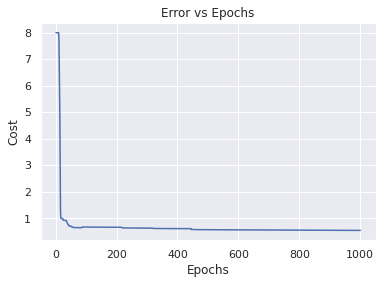

Number of epochs until convergence:1000

Training Accuracy
The accuracy is: 76.0%
Confusion Matrix: 


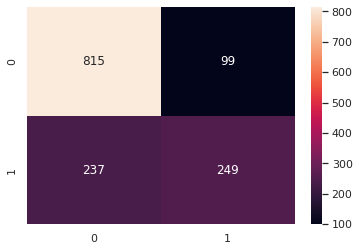

Validation Accuracy
The accuracy is: 76.55677655677655%
Confusion Matrix: 


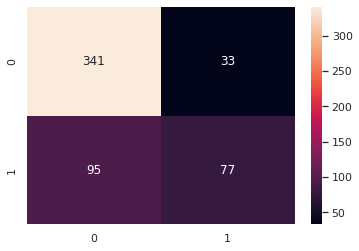

Test Accuracy
The accuracy is: 74.07407407407408%
Confusion Matrix: 


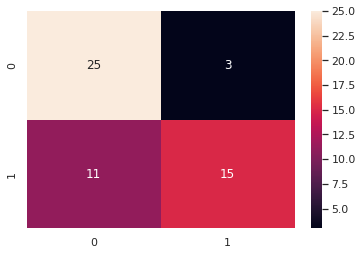

1 Layer with 4 Neurons


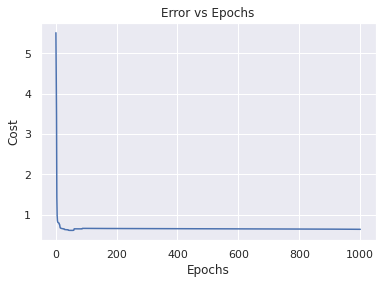

Number of epochs until convergence:1000

Training Accuracy
The accuracy is: 76.07142857142857%
Confusion Matrix: 


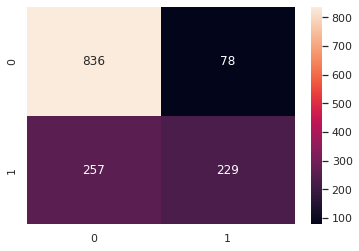

Validation Accuracy
The accuracy is: 76.92307692307693%
Confusion Matrix: 


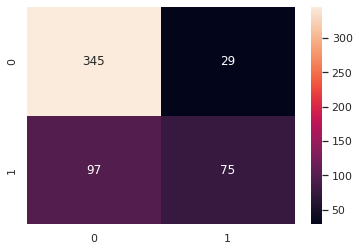

Test Accuracy
The accuracy is: 74.07407407407408%
Confusion Matrix: 


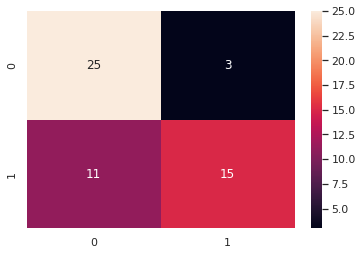

2 Layers with 8 Neurons


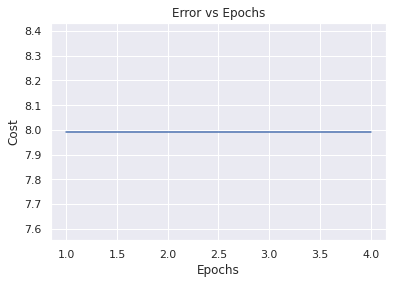

Number of epochs until convergence:4

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


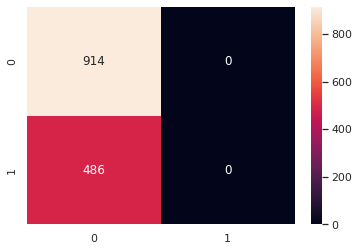

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


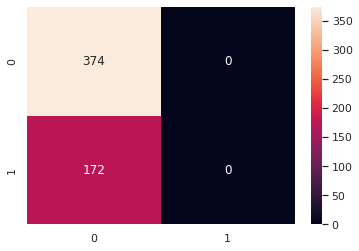

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


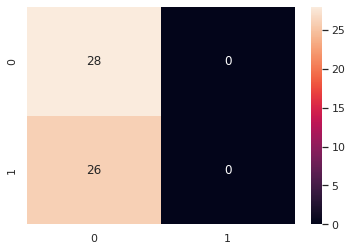

2 Layers with 4 Neurons


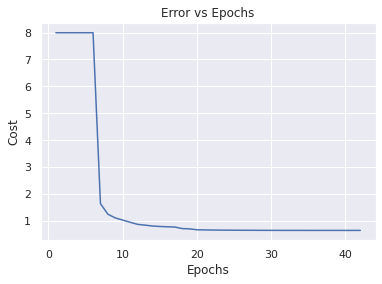

Number of epochs until convergence:42

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


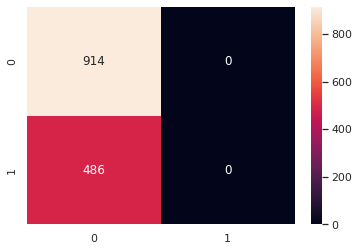

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


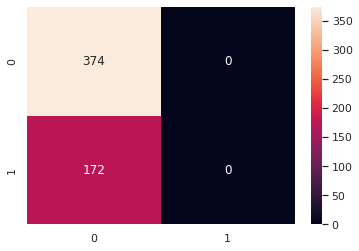

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


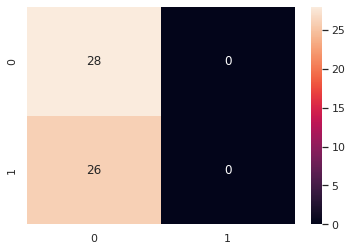

+---------------+-------------------+-----------------+-------------------+---------------------+------------------+
| Hidden Layers | Neurons in layers | Epochs to train | Training Accuracy | Validation Accuracy | Testing Accuracy |
+---------------+-------------------+-----------------+-------------------+---------------------+------------------+
|       1       |         8         |       1000      |        76.0       |        76.56        |      74.07       |
|       1       |         4         |       1000      |       76.07       |        76.92        |      74.07       |
|       2       |         8         |        4        |       65.29       |         68.5        |      51.85       |
|       2       |         4         |        42       |       65.29       |         68.5        |      51.85       |
+---------------+-------------------+-----------------+-------------------+---------------------+------------------+


In [30]:
print("1 Layer with 8 Neurons")
R18Weights, R18Epochs, R18Error, R18Activations = FitNN(trainx,trainy,1,[8],1,["relu","relu"],0.1,0,1000)
print("Number of epochs until convergence:"+str(R18Epochs)+"\n")
print("Training Accuracy")
R18_Acc=Predict(trainx,trainy,R18Weights,R18Activations)
print("Validation Accuracy")
R18_Acc_Val=Predict(validationx,validationy,R18Weights,R18Activations)
print("Test Accuracy")
R18_Acc_Test=Predict(testx,testy,R18Weights,R18Activations)

print("1 Layer with 4 Neurons")
R110Weights, R110Epochs, R110Error, R110Activations = FitNN(trainx,trainy,1,[4],1,["relu","relu"],0.1,0,1000)
print("Number of epochs until convergence:"+str(R110Epochs)+"\n")
print("Training Accuracy")
R110_Acc=Predict(trainx,trainy,R110Weights,R110Activations)
print("Validation Accuracy")
R110_Acc_Val=Predict(validationx,validationy,R110Weights,R110Activations)
print("Test Accuracy")
R110_Acc_Test=Predict(testx,testy,R110Weights,R110Activations)

print("2 Layers with 8 Neurons")
R28Weights, R28Epochs, R28Error, R28Activations = FitNN(trainx,trainy,2,[8,8],1,["relu","relu","relu"],0.1,0,1000)
print("Number of epochs until convergence:"+str(R28Epochs)+"\n")
print("Training Accuracy")
R28_Acc=Predict(trainx,trainy,R28Weights,R28Activations)
print("Validation Accuracy")
R28_Acc_Val=Predict(validationx,validationy,R28Weights,R28Activations)
print("Test Accuracy")
R28_Acc_Test=Predict(testx,testy,R28Weights,R28Activations)

print("2 Layers with 4 Neurons")
R210Weights, R210Epochs, R210Error, R210Activations = FitNN(trainx,trainy,2,[4,4],1,["relu","relu","relu"],0.1,0,1000)
print("Number of epochs until convergence:"+str(R210Epochs)+"\n")
print("Training Accuracy")
R210_Acc=Predict(trainx,trainy,R210Weights,R210Activations)
print("Validation Accuracy")
R210_Acc_Val=Predict(validationx,validationy,R210Weights,R210Activations)
print("Test Accuracy")
R210_Acc_Test=Predict(testx,testy,R210Weights,R210Activations)


ReluGen = PrettyTable(["Hidden Layers","Neurons in layers","Epochs to train","Training Accuracy","Validation Accuracy","Testing Accuracy"])

ReluGen.add_row(["1","8",R18Epochs,np.round(R18_Acc*100,2),np.round(R18_Acc_Val*100,2),np.round(R18_Acc_Test*100,2)])
ReluGen.add_row(["1","4",R110Epochs,np.round(R110_Acc*100,2),np.round(R110_Acc_Val*100,2),np.round(R110_Acc_Test*100,2)])
ReluGen.add_row(["2","8",R28Epochs,np.round(R28_Acc*100,2),np.round(R28_Acc_Val*100,2),np.round(R28_Acc_Test*100,2)])
ReluGen.add_row(["2","4",R210Epochs,np.round(R210_Acc*100,2),np.round(R210_Acc_Val*100,2),np.round(R210_Acc_Test*100,2)])
print(ReluGen)

### Sigmoid

#### 1 layer vs 2 layers

#### 8 Neurons vs 9 Neurons

1 Layer with 8 Neurons


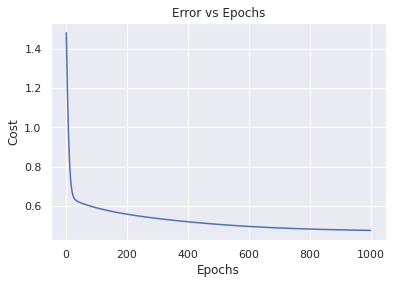

Number of epochs until convergence:1000

Training Accuracy
The accuracy is: 76.57142857142857%
Confusion Matrix: 


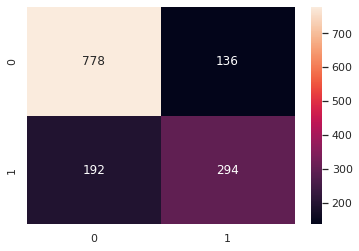

Validation Accuracy
The accuracy is: 77.83882783882784%
Confusion Matrix: 


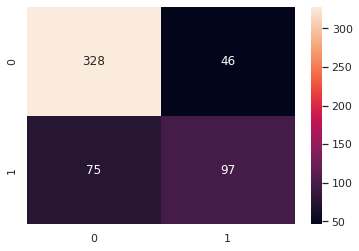

Test Accuracy
The accuracy is: 83.33333333333334%
Confusion Matrix: 


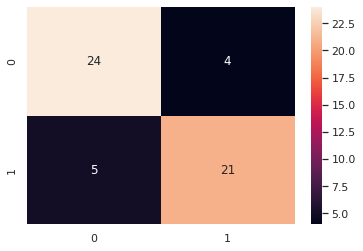

1 Layer with 9 Neurons


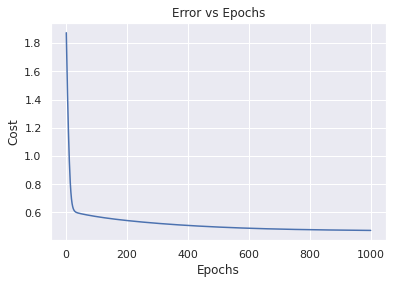

Number of epochs until convergence:1000

Training Accuracy
The accuracy is: 76.42857142857142%
Confusion Matrix: 


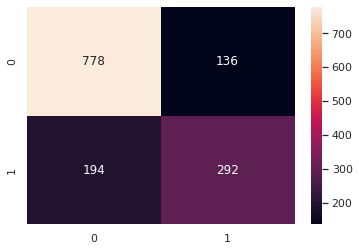

Validation Accuracy
The accuracy is: 79.3040293040293%
Confusion Matrix: 


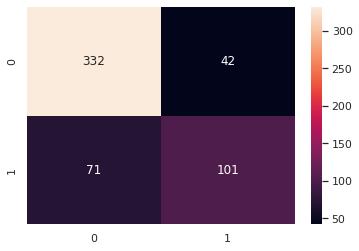

Test Accuracy
The accuracy is: 83.33333333333334%
Confusion Matrix: 


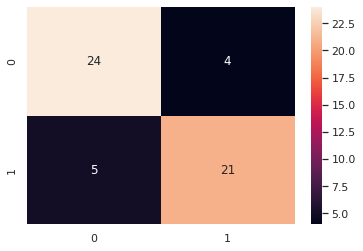

2 Layers with 8 Neurons


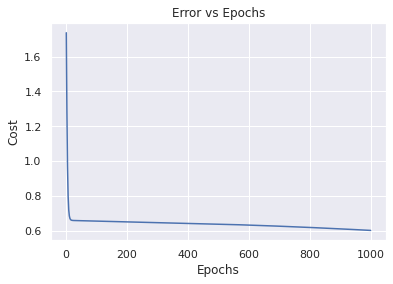

Number of epochs until convergence:1000

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


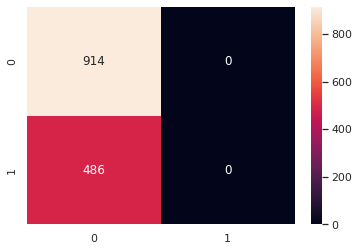

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


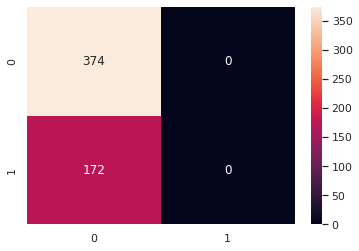

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


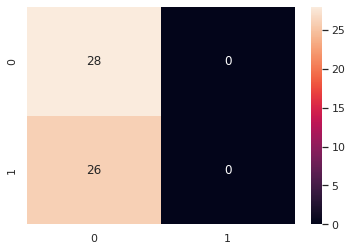

2 Layers with 9 Neurons


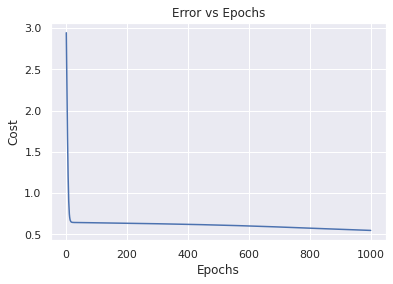

Number of epochs until convergence:1000

Training Accuracy
The accuracy is: 72.57142857142857%
Confusion Matrix: 


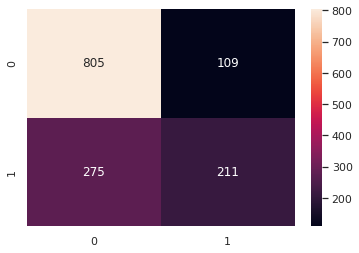

Validation Accuracy
The accuracy is: 74.9084249084249%
Confusion Matrix: 


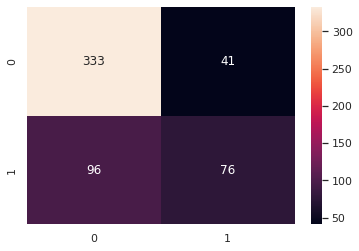

Test Accuracy
The accuracy is: 72.22222222222221%
Confusion Matrix: 


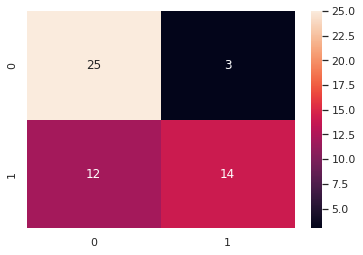

+---------------+-------------------+-----------------+-------------------+---------------------+------------------+
| Hidden Layers | Neurons in layers | Epochs to train | Training Accuracy | Validation Accuracy | Testing Accuracy |
+---------------+-------------------+-----------------+-------------------+---------------------+------------------+
|       1       |         8         |       1000      |       76.57       |        77.84        |      83.33       |
|       1       |         9         |       1000      |       76.43       |         79.3        |      83.33       |
|       2       |         8         |       1000      |       65.29       |         68.5        |      51.85       |
|       2       |         9         |       1000      |       72.57       |        74.91        |      72.22       |
+---------------+-------------------+-----------------+-------------------+---------------------+------------------+


In [31]:
print("1 Layer with 8 Neurons")
S18Weights, S18Epochs, S18Error, S18Activations = FitNN(trainx,trainy,1,[8],1,["sigmoid","sigmoid"],0.1,0,1000)
print("Number of epochs until convergence:"+str(S18Epochs)+"\n")
print("Training Accuracy")
S18_Acc=Predict(trainx,trainy,S18Weights,S18Activations)
print("Validation Accuracy")
S18_Acc_Val=Predict(validationx,validationy,S18Weights,S18Activations)
print("Test Accuracy")
S18_Acc_Test=Predict(testx,testy,S18Weights,S18Activations)

print("1 Layer with 9 Neurons")
S110Weights, S110Epochs, S110Error, S110Activations = FitNN(trainx,trainy,1,[9],1,["sigmoid","sigmoid"],0.1,0,1000)
print("Number of epochs until convergence:"+str(S110Epochs)+"\n")
print("Training Accuracy")
S110_Acc=Predict(trainx,trainy,S110Weights,S110Activations)
print("Validation Accuracy")
S110_Acc_Val=Predict(validationx,validationy,S110Weights,S110Activations)
print("Test Accuracy")
S110_Acc_Test=Predict(testx,testy,S110Weights,S110Activations)

print("2 Layers with 8 Neurons")
S28Weights, S28Epochs, S28Error, S28Activations = FitNN(trainx,trainy,2,[8,8],1,["sigmoid","sigmoid","sigmoid"],0.1,0,1000)
print("Number of epochs until convergence:"+str(S28Epochs)+"\n")
print("Training Accuracy")
S28_Acc=Predict(trainx,trainy,S28Weights,S28Activations)
print("Validation Accuracy")
S28_Acc_Val=Predict(validationx,validationy,S28Weights,S28Activations)
print("Test Accuracy")
S28_Acc_Test=Predict(testx,testy,S28Weights,S28Activations)

print("2 Layers with 9 Neurons")
S210Weights, S210Epochs, S210Error, S210Activations = FitNN(trainx,trainy,2,[9,9],1,["sigmoid","sigmoid","sigmoid"],0.1,0,1000)
print("Number of epochs until convergence:"+str(S210Epochs)+"\n")
print("Training Accuracy")
S210_Acc=Predict(trainx,trainy,S210Weights,S210Activations)
print("Validation Accuracy")
S210_Acc_Val=Predict(validationx,validationy,S210Weights,S210Activations)
print("Test Accuracy")
S210_Acc_Test=Predict(testx,testy,S210Weights,S210Activations)


SigmoidGen = PrettyTable(["Hidden Layers","Neurons in layers","Epochs to train","Training Accuracy","Validation Accuracy","Testing Accuracy"])

SigmoidGen.add_row(["1","8",S18Epochs,np.round(S18_Acc*100,2),np.round(S18_Acc_Val*100,2),np.round(S18_Acc_Test*100,2)])
SigmoidGen.add_row(["1","9",S110Epochs,np.round(S110_Acc*100,2),np.round(S110_Acc_Val*100,2),np.round(S110_Acc_Test*100,2)])
SigmoidGen.add_row(["2","8",S28Epochs,np.round(S28_Acc*100,2),np.round(S28_Acc_Val*100,2),np.round(S28_Acc_Test*100,2)])
SigmoidGen.add_row(["2","9",S210Epochs,np.round(S210_Acc*100,2),np.round(S210_Acc_Val*100,2),np.round(S210_Acc_Test*100,2)])
print(SigmoidGen)

### Tanh

#### 1 layer vs 2 layers

#### 3 Neurons per layer vs 18 Neurons per layer

1 Layer with 3 Neurons


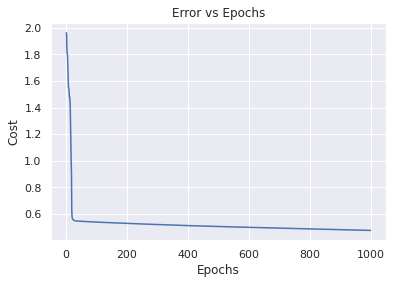

Number of epochs until convergence:1000

Training Accuracy
The accuracy is: 77.28571428571429%
Confusion Matrix: 


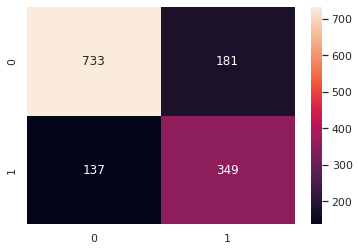

Validation Accuracy
The accuracy is: 78.3882783882784%
Confusion Matrix: 


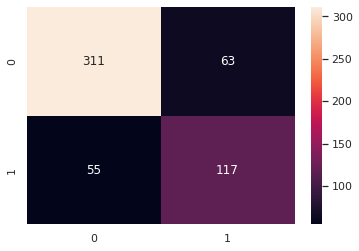

Test Accuracy
The accuracy is: 85.18518518518519%
Confusion Matrix: 


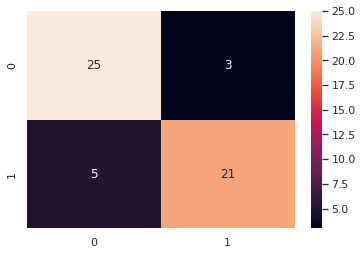

1 Layer with 18 Neurons


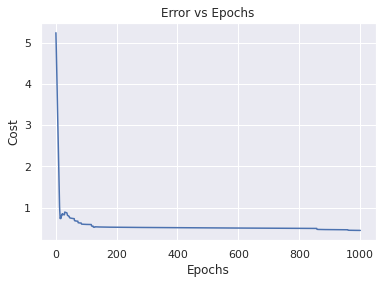

Number of epochs until convergence:1000

Training Accuracy
The accuracy is: 78.57142857142857%
Confusion Matrix: 


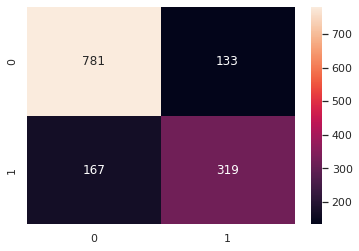

Validation Accuracy
The accuracy is: 78.93772893772893%
Confusion Matrix: 


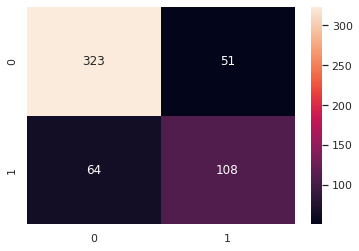

Test Accuracy
The accuracy is: 87.03703703703704%
Confusion Matrix: 


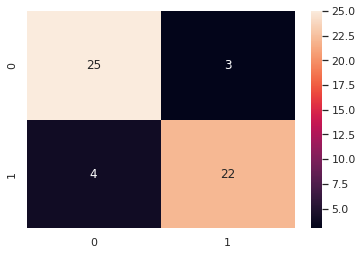

2 Layers with 3 Neurons


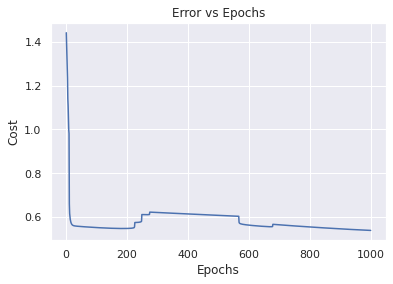

Number of epochs until convergence:1000

Training Accuracy
The accuracy is: 76.28571428571429%
Confusion Matrix: 


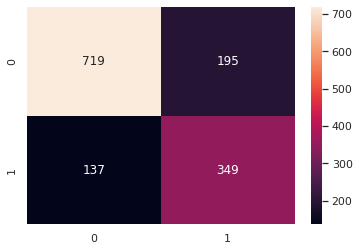

Validation Accuracy
The accuracy is: 76.73992673992674%
Confusion Matrix: 


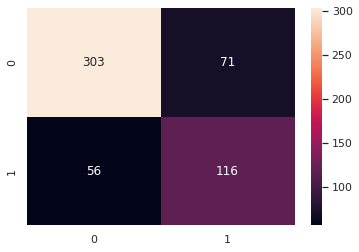

Test Accuracy
The accuracy is: 81.48148148148148%
Confusion Matrix: 


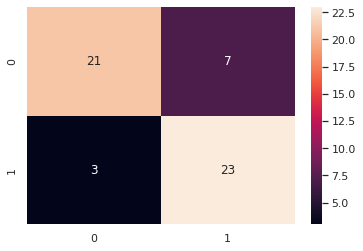

2 Layers with 18 Neurons


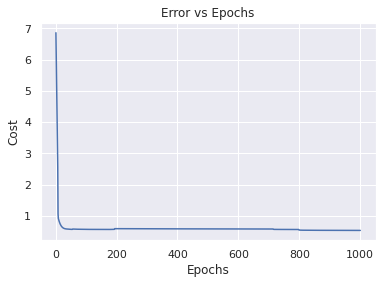

Number of epochs until convergence:1000

Training Accuracy
The accuracy is: 70.07142857142857%
Confusion Matrix: 


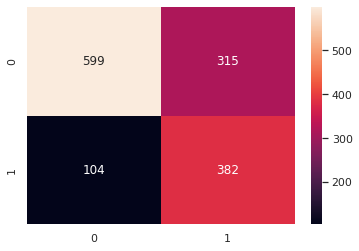

Validation Accuracy
The accuracy is: 69.78021978021978%
Confusion Matrix: 


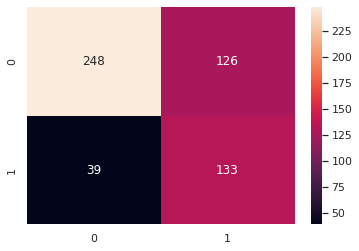

Test Accuracy
The accuracy is: 66.66666666666666%
Confusion Matrix: 


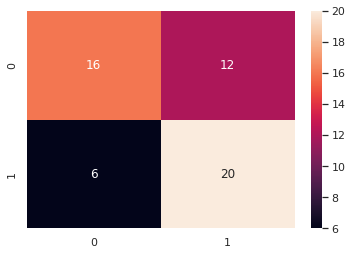

+---------------+-------------------+-----------------+-------------------+---------------------+------------------+
| Hidden Layers | Neurons in layers | Epochs to train | Training Accuracy | Validation Accuracy | Testing Accuracy |
+---------------+-------------------+-----------------+-------------------+---------------------+------------------+
|       1       |         3         |       1000      |       77.29       |        78.39        |      85.19       |
|       1       |         18        |       1000      |       78.57       |        78.94        |      87.04       |
|       2       |         3         |       1000      |       76.29       |        76.74        |      81.48       |
|       2       |         18        |       1000      |       70.07       |        69.78        |      66.67       |
+---------------+-------------------+-----------------+-------------------+---------------------+------------------+


In [32]:
print("1 Layer with 3 Neurons")
T18Weights, T18Epochs, T18Error, T18Activations = FitNN(trainx,trainy,1,[3],1,["tanh","tanh"],0.1,0,1000)
print("Number of epochs until convergence:"+str(T18Epochs)+"\n")
print("Training Accuracy")
T18_Acc=Predict(trainx,trainy,T18Weights,T18Activations)
print("Validation Accuracy")
T18_Acc_Val=Predict(validationx,validationy,T18Weights,T18Activations)
print("Test Accuracy")
T18_Acc_Test=Predict(testx,testy,T18Weights,T18Activations)

print("1 Layer with 18 Neurons")
T110Weights, T110Epochs, T110Error, T110Activations = FitNN(trainx,trainy,1,[18],1,["tanh","tanh"],0.1,0,1000)
print("Number of epochs until convergence:"+str(T110Epochs)+"\n")
print("Training Accuracy")
T110_Acc=Predict(trainx,trainy,T110Weights,T110Activations)
print("Validation Accuracy")
T110_Acc_Val=Predict(validationx,validationy,T110Weights,T110Activations)
print("Test Accuracy")
T110_Acc_Test=Predict(testx,testy,T110Weights,T110Activations)

print("2 Layers with 3 Neurons")
T28Weights, T28Epochs, T28Error, T28Activations = FitNN(trainx,trainy,2,[3,3],1,["tanh","tanh","tanh"],0.1,0,1000)
print("Number of epochs until convergence:"+str(T28Epochs)+"\n")
print("Training Accuracy")
T28_Acc=Predict(trainx,trainy,T28Weights,T28Activations)
print("Validation Accuracy")
T28_Acc_Val=Predict(validationx,validationy,T28Weights,T28Activations)
print("Test Accuracy")
T28_Acc_Test=Predict(testx,testy,T28Weights,T28Activations)

print("2 Layers with 18 Neurons")
T210Weights, T210Epochs, T210Error, T210Activations = FitNN(trainx,trainy,2,[18,18],1,["tanh","tanh","tanh"],0.1,0,1000)
print("Number of epochs until convergence:"+str(T210Epochs)+"\n")
print("Training Accuracy")
T210_Acc=Predict(trainx,trainy,T210Weights,T210Activations)
print("Validation Accuracy")
T210_Acc_Val=Predict(validationx,validationy,T210Weights,T210Activations)
print("Test Accuracy")
T210_Acc_Test=Predict(testx,testy,T210Weights,T210Activations)


TanhGen = PrettyTable(["Hidden Layers","Neurons in layers","Epochs to train","Training Accuracy","Validation Accuracy","Testing Accuracy"])

TanhGen.add_row(["1","3",T18Epochs,np.round(T18_Acc*100,2),np.round(T18_Acc_Val*100,2),np.round(T18_Acc_Test*100,2)])
TanhGen.add_row(["1","18",T110Epochs,np.round(T110_Acc*100,2),np.round(T110_Acc_Val*100,2),np.round(T110_Acc_Test*100,2)])
TanhGen.add_row(["2","3",T28Epochs,np.round(T28_Acc*100,2),np.round(T28_Acc_Val*100,2),np.round(T28_Acc_Test*100,2)])
TanhGen.add_row(["2","18",T210Epochs,np.round(T210_Acc*100,2),np.round(T210_Acc_Val*100,2),np.round(T210_Acc_Test*100,2)])
print(TanhGen)

# Discussing results

In [33]:
print("Initial results with 2 layers with 2 neurons each")
print(InitialResults)

Initial results with 2 layers with 2 neurons each
+---------------------+-----------------+-------------------+---------------------+------------------+
| Activation Function | Epochs to train | Training Accuracy | Validation Accuracy | Testing Accuracy |
+---------------------+-----------------+-------------------+---------------------+------------------+
|         ReLu        |       100       |       72.64       |        74.54        |      70.37       |
|       Sigmoid       |       100       |       65.29       |         68.5        |      51.85       |
|         Tanh        |       100       |       69.36       |        71.98        |      68.52       |
+---------------------+-----------------+-------------------+---------------------+------------------+


In [34]:
print("Relu activation function with different network sizes")
print(ReluGen)

Relu activation function with different network sizes
+---------------+-------------------+-----------------+-------------------+---------------------+------------------+
| Hidden Layers | Neurons in layers | Epochs to train | Training Accuracy | Validation Accuracy | Testing Accuracy |
+---------------+-------------------+-----------------+-------------------+---------------------+------------------+
|       1       |         8         |       1000      |        76.0       |        76.56        |      74.07       |
|       1       |         4         |       1000      |       76.07       |        76.92        |      74.07       |
|       2       |         8         |        4        |       65.29       |         68.5        |      51.85       |
|       2       |         4         |        42       |       65.29       |         68.5        |      51.85       |
+---------------+-------------------+-----------------+-------------------+---------------------+------------------+


In [35]:
print("Sigmoid activation function with different network sizes")
print(SigmoidGen)

Sigmoid activation function with different network sizes
+---------------+-------------------+-----------------+-------------------+---------------------+------------------+
| Hidden Layers | Neurons in layers | Epochs to train | Training Accuracy | Validation Accuracy | Testing Accuracy |
+---------------+-------------------+-----------------+-------------------+---------------------+------------------+
|       1       |         8         |       1000      |       76.57       |        77.84        |      83.33       |
|       1       |         9         |       1000      |       76.43       |         79.3        |      83.33       |
|       2       |         8         |       1000      |       65.29       |         68.5        |      51.85       |
|       2       |         9         |       1000      |       72.57       |        74.91        |      72.22       |
+---------------+-------------------+-----------------+-------------------+---------------------+------------------+


In [36]:
print("Tanh activation function with different network sizes")
print(TanhGen)

Tanh activation function with different network sizes
+---------------+-------------------+-----------------+-------------------+---------------------+------------------+
| Hidden Layers | Neurons in layers | Epochs to train | Training Accuracy | Validation Accuracy | Testing Accuracy |
+---------------+-------------------+-----------------+-------------------+---------------------+------------------+
|       1       |         3         |       1000      |       77.29       |        78.39        |      85.19       |
|       1       |         18        |       1000      |       78.57       |        78.94        |      87.04       |
|       2       |         3         |       1000      |       76.29       |        76.74        |      81.48       |
|       2       |         18        |       1000      |       70.07       |        69.78        |      66.67       |
+---------------+-------------------+-----------------+-------------------+---------------------+------------------+


There has been a use of three activation functions namely:
-Relu
-Sigmoid
-Tanh
These have been used to examine the different effects that they have on the same data.
When looking at the initial accuracies when using 2 hidden layers with 2 nodes each, the tanh activation function seems to out peform the other two for the training and validation, however the Relu and Sigmoid functions do the best when it comes to the hidden test data. Therefore implying that the relu and sigmoid functions are less fitted to the training data.

Thereafter, for each activation function we have looked at the effect of different network sizes. Each activation function has been provided with different network sizes that seem to provide optimal results.

The Relu function with 1 hidden layer consisting of 8 nodes performed the best overall when averaging the accuracies over the training, validation and testing data.

The learning rate and regularization has been consistent throughout, so we shall now study the effect of these using the best performing network from the previous observations.

# Different learning rates

Learning Rate:1.0


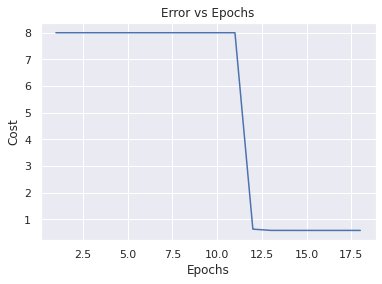

Number of epochs until convergence:18

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


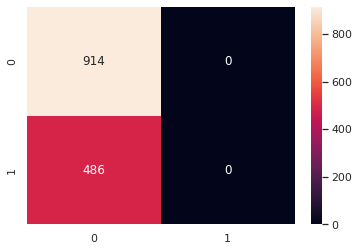

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


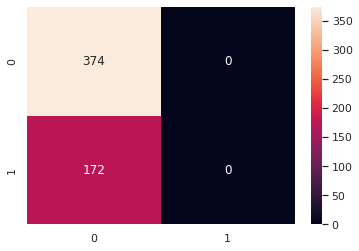

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


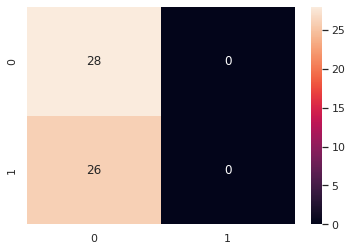

Learning Rate:0.1


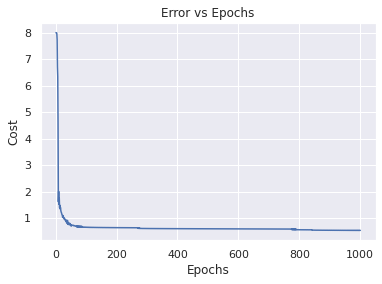

Number of epochs until convergence:1000

Training Accuracy
The accuracy is: 74.92857142857143%
Confusion Matrix: 


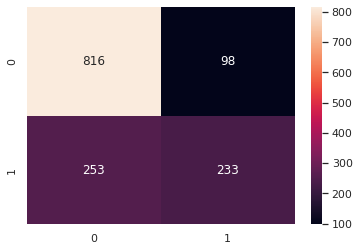

Validation Accuracy
The accuracy is: 76.007326007326%
Confusion Matrix: 


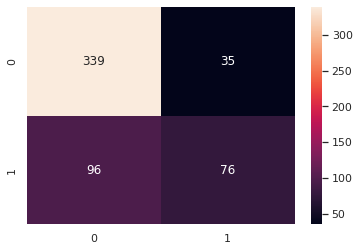

Test Accuracy
The accuracy is: 74.07407407407408%
Confusion Matrix: 


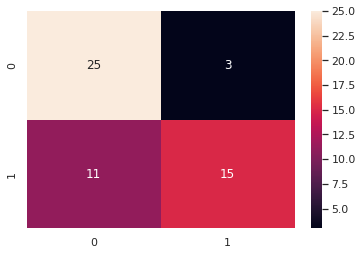

Learning Rate:0.01


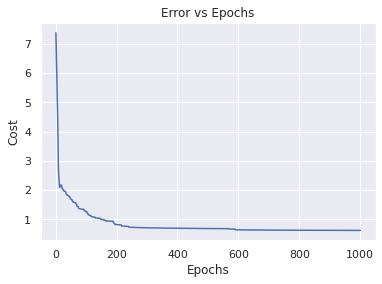

Number of epochs until convergence:1000

Training Accuracy
The accuracy is: 74.21428571428571%
Confusion Matrix: 


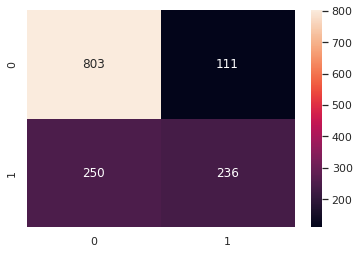

Validation Accuracy
The accuracy is: 75.64102564102564%
Confusion Matrix: 


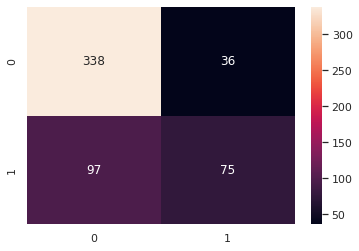

Test Accuracy
The accuracy is: 77.77777777777779%
Confusion Matrix: 


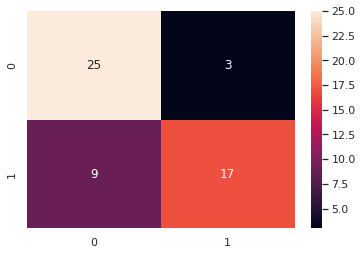

Learning Rate:0.001


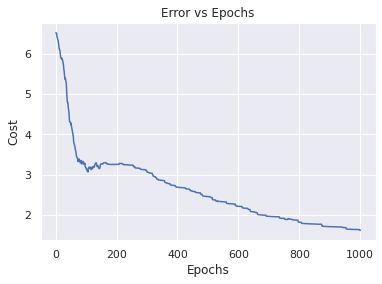

Number of epochs until convergence:1000

Training Accuracy
The accuracy is: 67.42857142857143%
Confusion Matrix: 


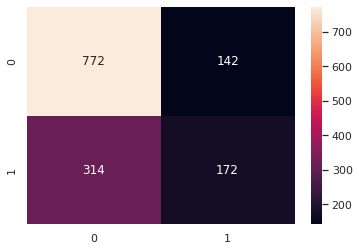

Validation Accuracy
The accuracy is: 67.76556776556777%
Confusion Matrix: 


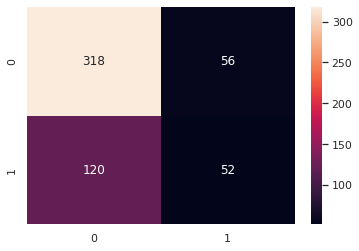

Test Accuracy
The accuracy is: 59.25925925925925%
Confusion Matrix: 


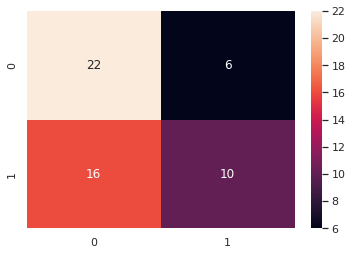

Learning Rate:0.0001


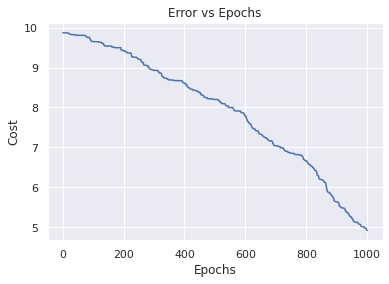

Number of epochs until convergence:1000

Training Accuracy
The accuracy is: 34.785714285714285%
Confusion Matrix: 


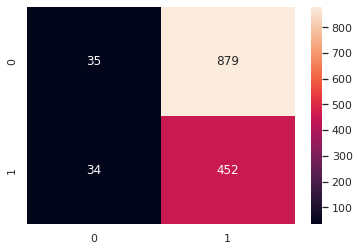

Validation Accuracy
The accuracy is: 34.065934065934066%
Confusion Matrix: 


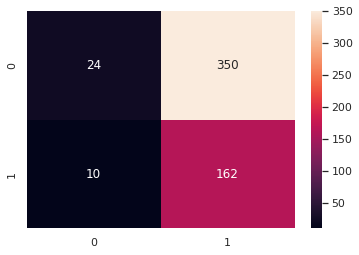

Test Accuracy
The accuracy is: 48.148148148148145%
Confusion Matrix: 


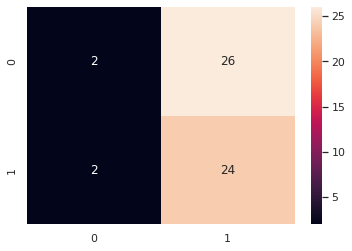

Learning Rate:1e-05


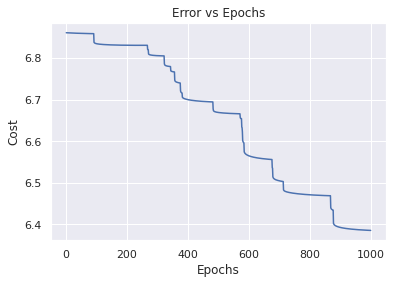

Number of epochs until convergence:1000

Training Accuracy
The accuracy is: 57.85714285714286%
Confusion Matrix: 


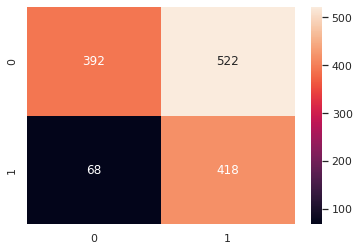

Validation Accuracy
The accuracy is: 55.311355311355314%
Confusion Matrix: 


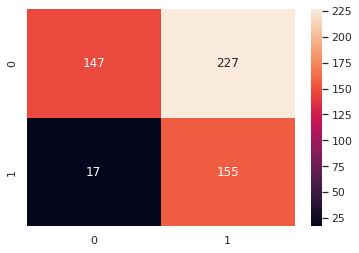

Test Accuracy
The accuracy is: 59.25925925925925%
Confusion Matrix: 


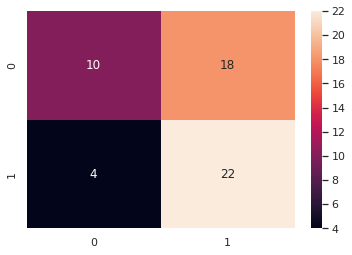

Learning Rate:1e-06


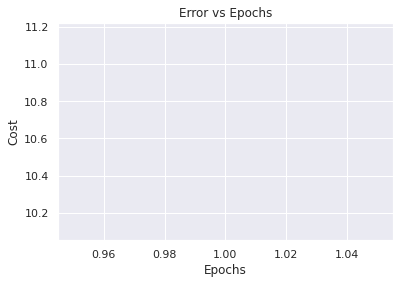

Number of epochs until convergence:1

Training Accuracy
The accuracy is: 34.714285714285715%
Confusion Matrix: 


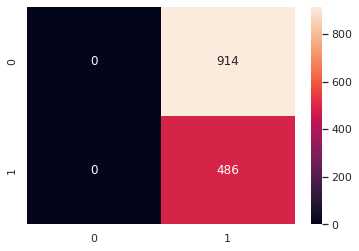

Validation Accuracy
The accuracy is: 31.5018315018315%
Confusion Matrix: 


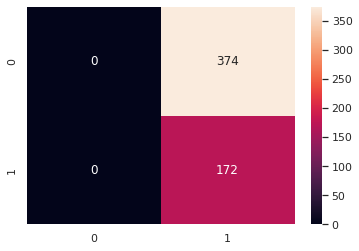

Test Accuracy
The accuracy is: 48.148148148148145%
Confusion Matrix: 


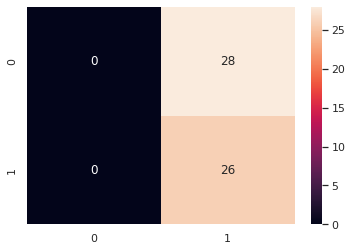

Learning Rate:1e-07


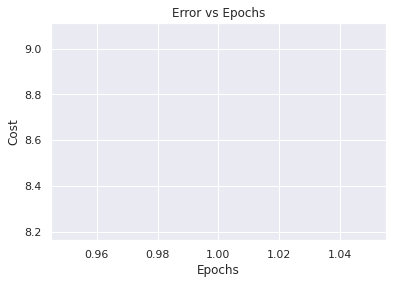

Number of epochs until convergence:1

Training Accuracy
The accuracy is: 34.714285714285715%
Confusion Matrix: 


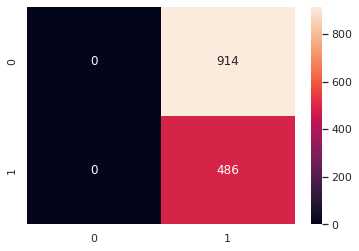

Validation Accuracy
The accuracy is: 31.5018315018315%
Confusion Matrix: 


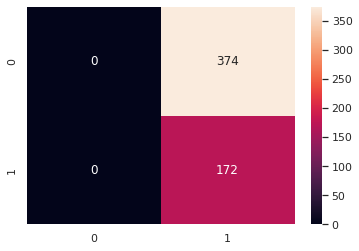

Test Accuracy
The accuracy is: 48.148148148148145%
Confusion Matrix: 


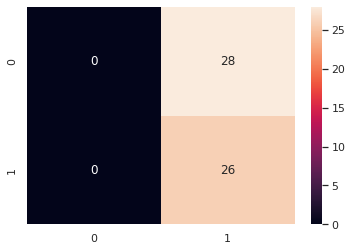

Learning Rate:1e-08


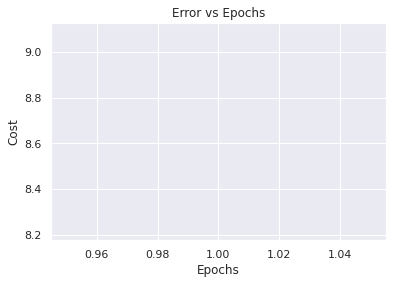

Number of epochs until convergence:1

Training Accuracy
The accuracy is: 34.714285714285715%
Confusion Matrix: 


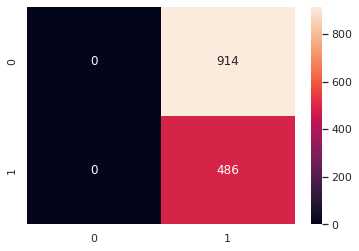

Validation Accuracy
The accuracy is: 31.5018315018315%
Confusion Matrix: 


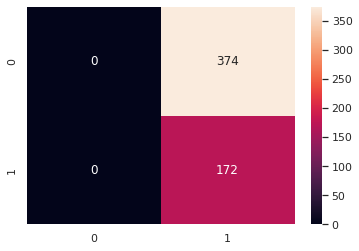

Test Accuracy
The accuracy is: 48.148148148148145%
Confusion Matrix: 


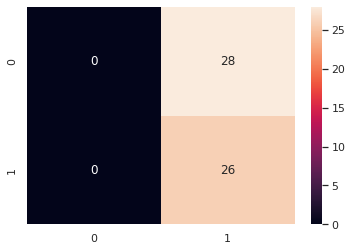

Learning Rate:1e-09


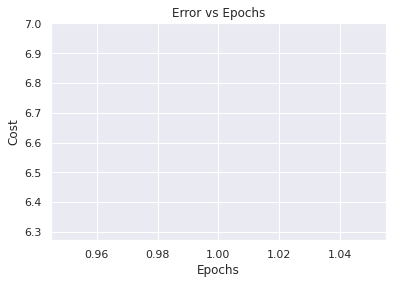

Number of epochs until convergence:1

Training Accuracy
The accuracy is: 57.92857142857143%
Confusion Matrix: 


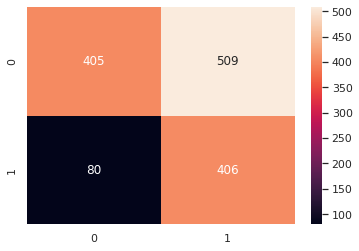

Validation Accuracy
The accuracy is: 56.41025641025641%
Confusion Matrix: 


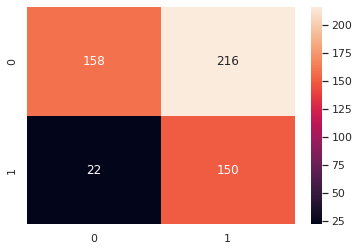

Test Accuracy
The accuracy is: 57.407407407407405%
Confusion Matrix: 


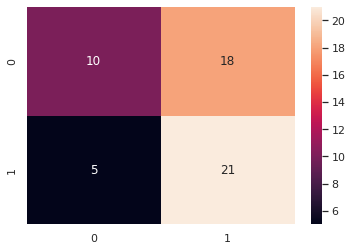

+---------------+-----------------+-------------------+---------------------+------------------+
| Learning Rate | Epochs to train | Training Accuracy | Validation Accuracy | Testing Accuracy |
+---------------+-----------------+-------------------+---------------------+------------------+
|      1.0      |        18       |       65.29       |         68.5        |      51.85       |
|      0.1      |       1000      |       74.93       |        76.01        |      74.07       |
|      0.01     |       1000      |       74.21       |        75.64        |      77.78       |
|     0.001     |       1000      |       67.43       |        67.77        |      59.26       |
|     0.0001    |       1000      |       34.79       |        34.07        |      48.15       |
|     1e-05     |       1000      |       57.86       |        55.31        |      59.26       |
|     1e-06     |        1        |       34.71       |         31.5        |      48.15       |
|     1e-07     |        1    

In [37]:
LearningResults = PrettyTable(["Learning Rate","Epochs to train","Training Accuracy","Validation Accuracy","Testing Accuracy"])

for i in range(10):
    print("Learning Rate:"+str(1/10**i))
    R18Weights, R18Epochs, R18Error, R18Activations = FitNN(trainx,trainy,1,[8],1,["relu","relu"],1/10**i,0,1000)
    print("Number of epochs until convergence:"+str(R18Epochs)+"\n")
    print("Training Accuracy")
    R18_Acc=Predict(trainx,trainy,R18Weights,R18Activations)
    print("Validation Accuracy")
    R18_Acc_Val=Predict(validationx,validationy,R18Weights,R18Activations)
    print("Test Accuracy")
    R18_Acc_Test=Predict(testx,testy,R18Weights,R18Activations)
    LearningResults.add_row([1/10**i,R18Epochs,np.round(R18_Acc*100,2),np.round(R18_Acc_Val*100,2),np.round(R18_Acc_Test*100,2)])


print(LearningResults)

As seen by the table above, the learning rates of 0.1 and 0.01 produce the best results. Once the learning rate is 0.000001 or smaller, the results converge after 1 epoch, due to the fact that the learning rate is too low.

# Different Regularization

Regularization:0.0


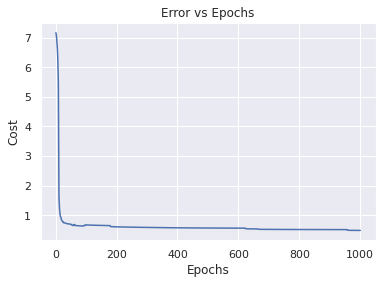

Number of epochs until convergence:1000

Training Accuracy
The accuracy is: 77.35714285714286%
Confusion Matrix: 


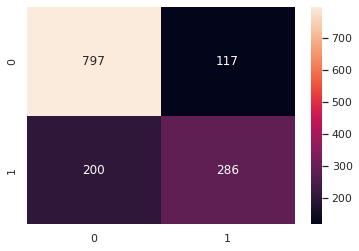

Validation Accuracy
The accuracy is: 78.2051282051282%
Confusion Matrix: 


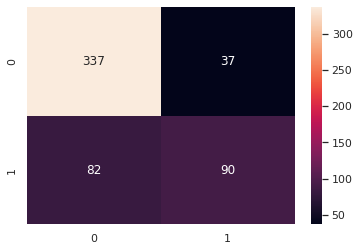

Test Accuracy
The accuracy is: 77.77777777777779%
Confusion Matrix: 


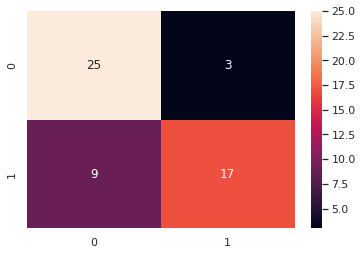

Regularization:0.1


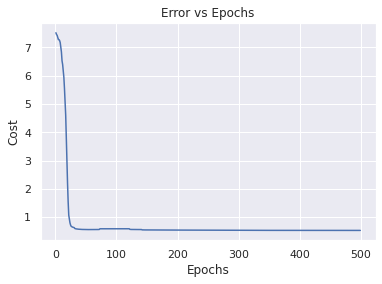

Number of epochs until convergence:499

Training Accuracy
The accuracy is: 74.71428571428571%
Confusion Matrix: 


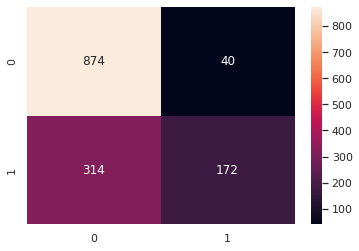

Validation Accuracy
The accuracy is: 75.27472527472527%
Confusion Matrix: 


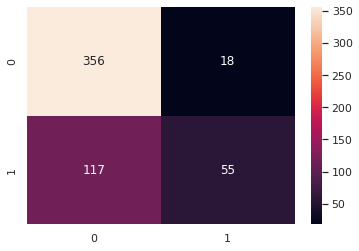

Test Accuracy
The accuracy is: 72.22222222222221%
Confusion Matrix: 


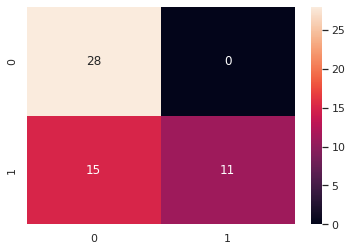

Regularization:0.2


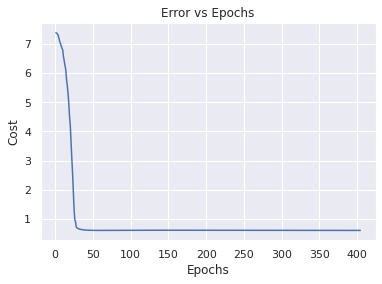

Number of epochs until convergence:404

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


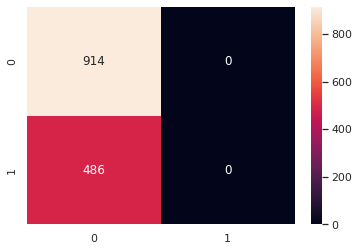

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


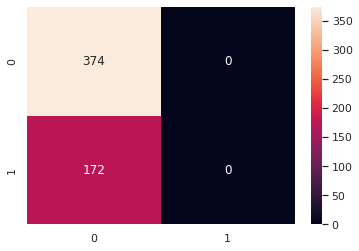

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


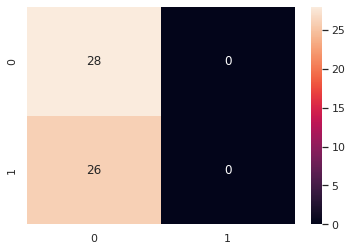

Regularization:0.30000000000000004


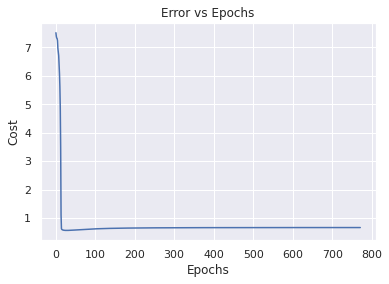

Number of epochs until convergence:771

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


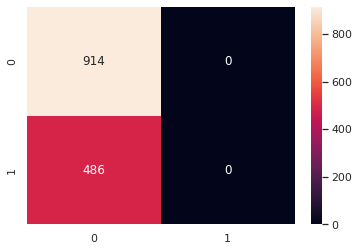

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


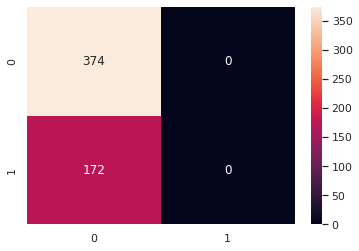

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


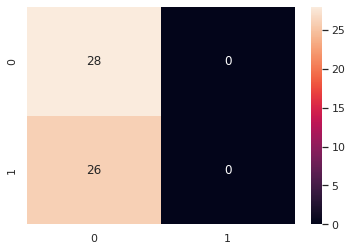

Regularization:0.4


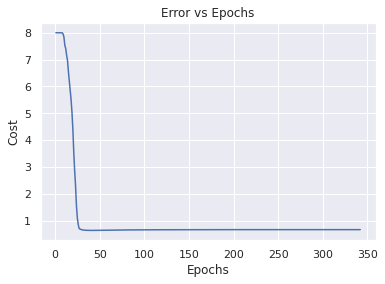

Number of epochs until convergence:342

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


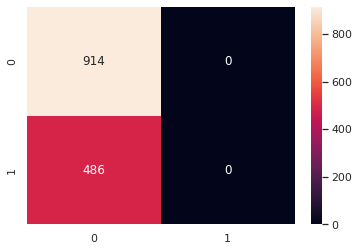

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


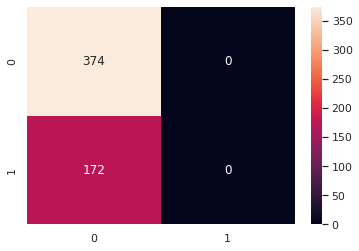

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


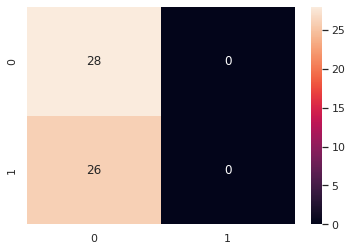

Regularization:0.5


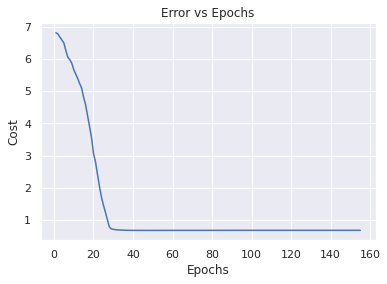

Number of epochs until convergence:155

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


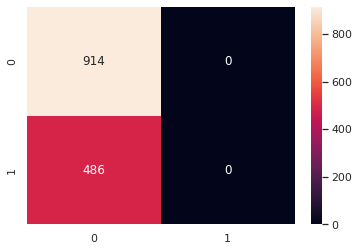

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


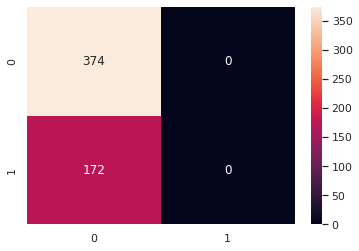

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


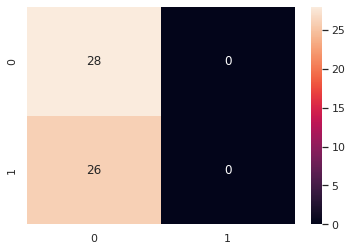

Regularization:0.6000000000000001


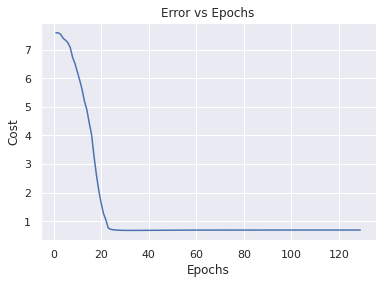

Number of epochs until convergence:129

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


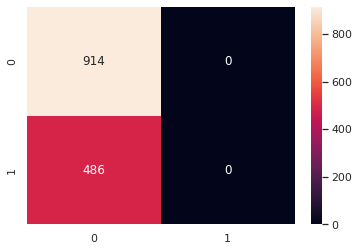

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


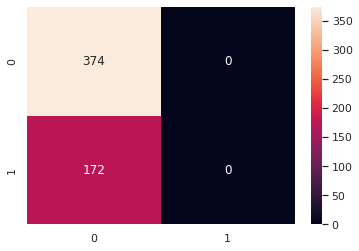

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


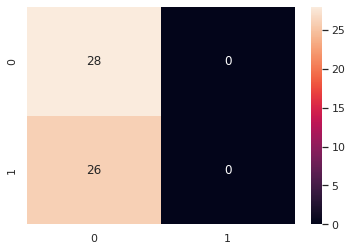

Regularization:0.7000000000000001


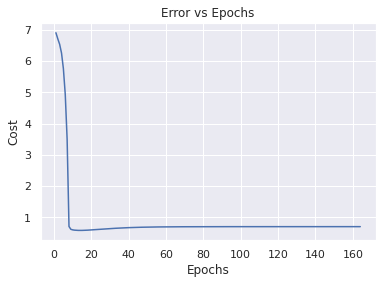

Number of epochs until convergence:164

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


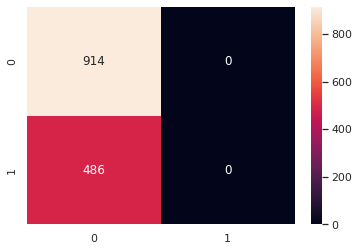

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


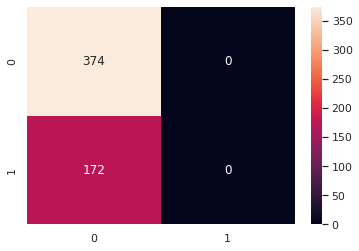

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


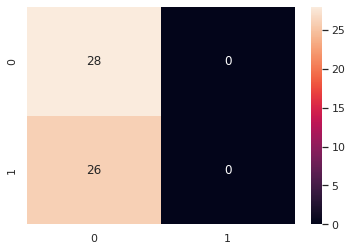

Regularization:0.8


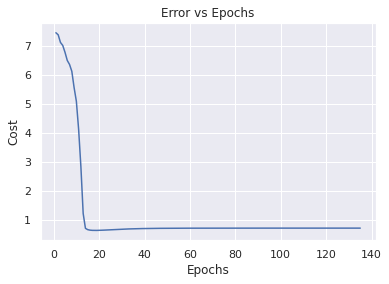

Number of epochs until convergence:135

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


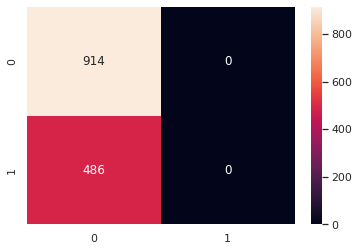

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


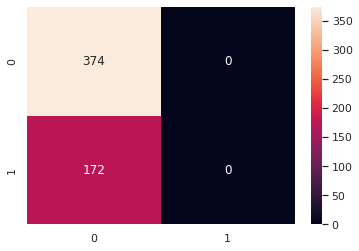

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


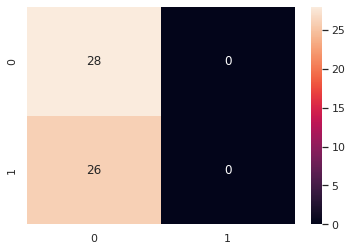

Regularization:0.9


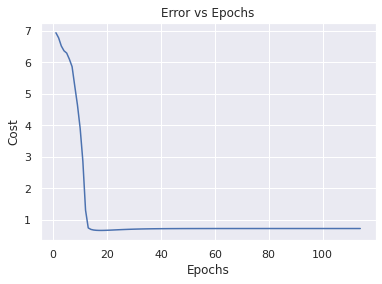

Number of epochs until convergence:114

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


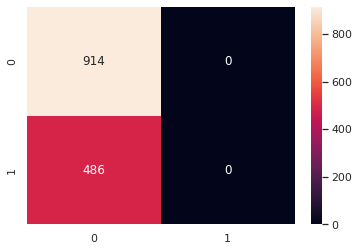

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


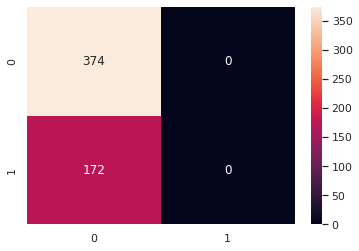

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


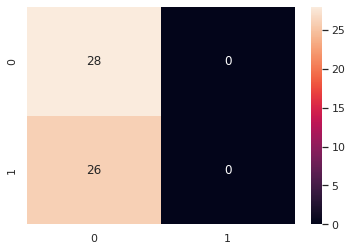

Regularization:1.0


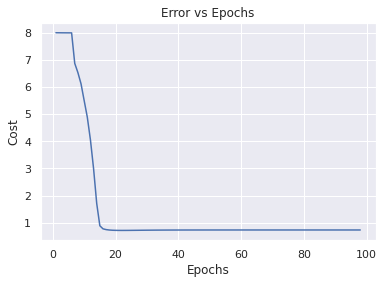

Number of epochs until convergence:98

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


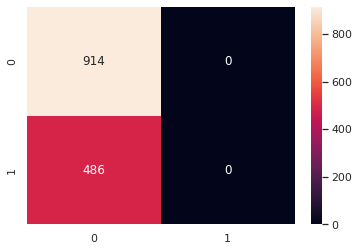

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


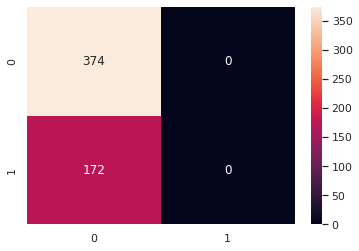

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


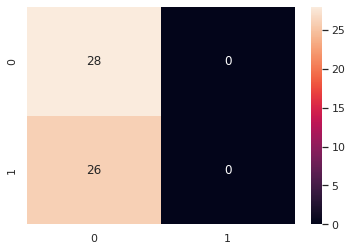

Regularization:1.1


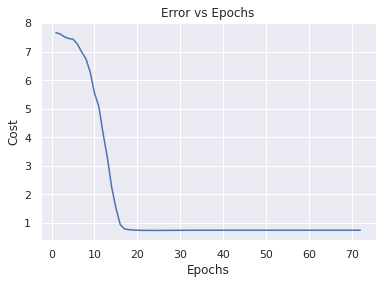

Number of epochs until convergence:72

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


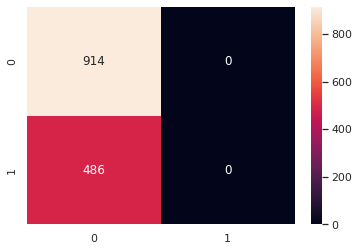

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


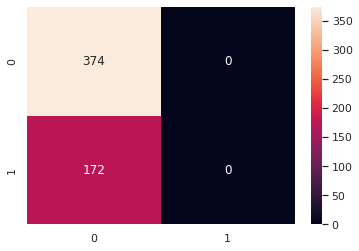

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


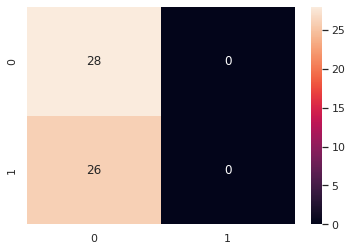

Regularization:1.2000000000000002


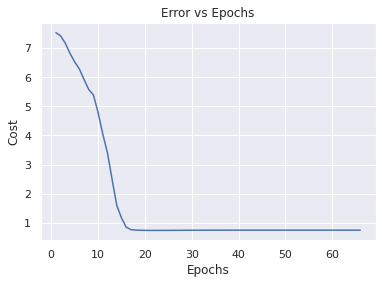

Number of epochs until convergence:66

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


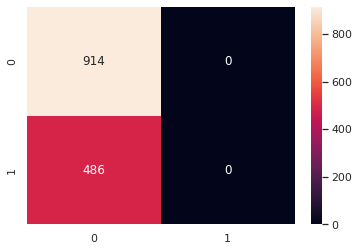

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


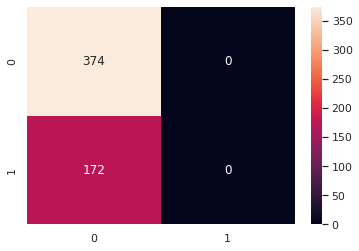

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


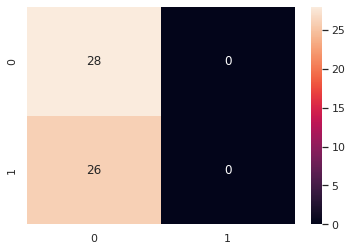

Regularization:1.3


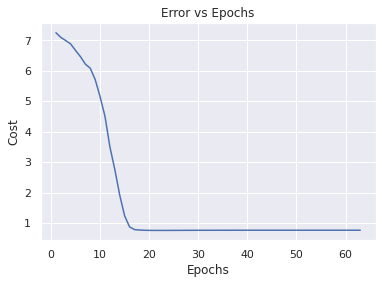

Number of epochs until convergence:63

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


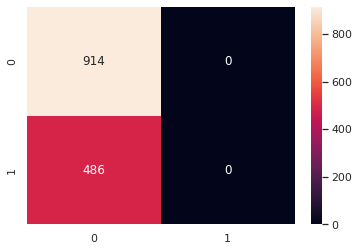

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


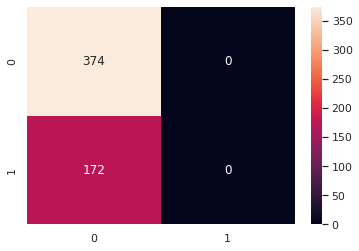

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


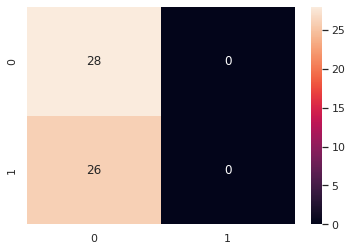

Regularization:1.4000000000000001


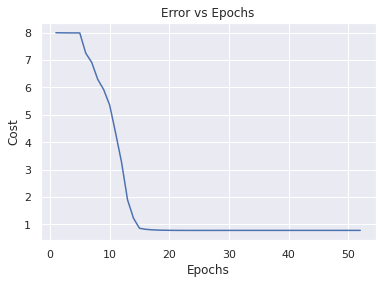

Number of epochs until convergence:52

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


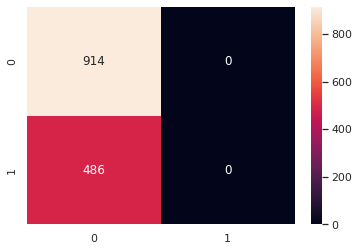

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


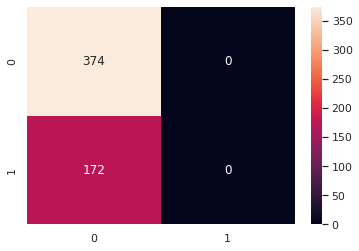

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


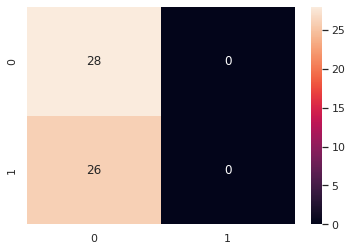

Regularization:1.5


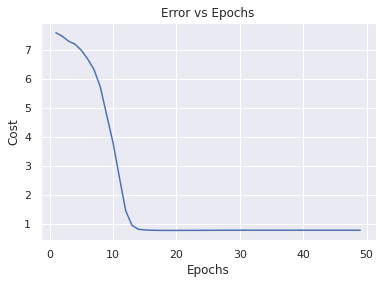

Number of epochs until convergence:49

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


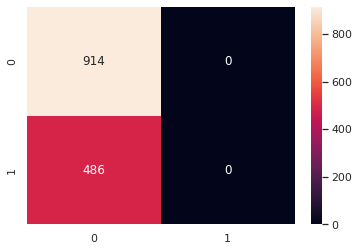

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


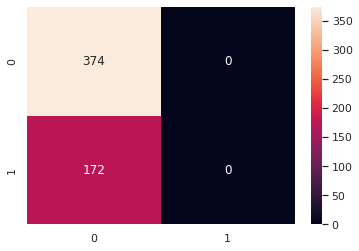

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


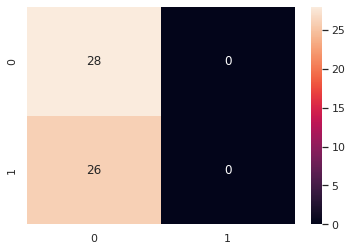

Regularization:1.6


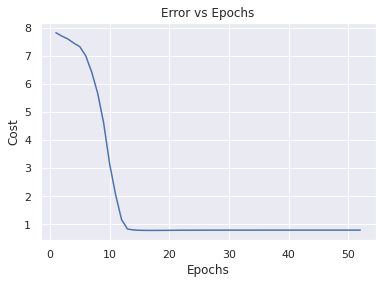

Number of epochs until convergence:52

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


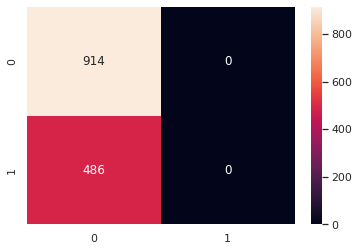

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


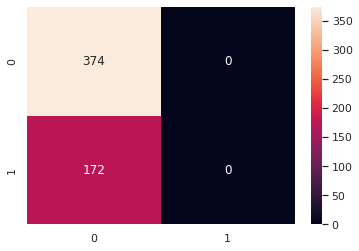

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


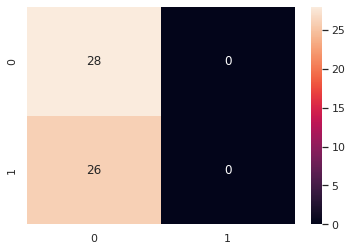

Regularization:1.7000000000000002


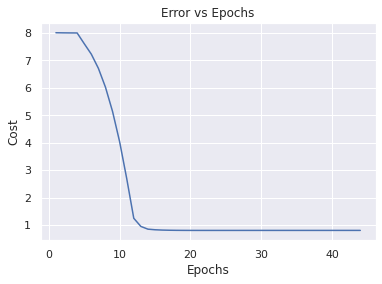

Number of epochs until convergence:44

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


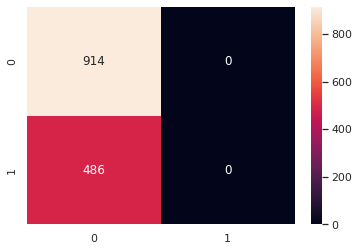

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


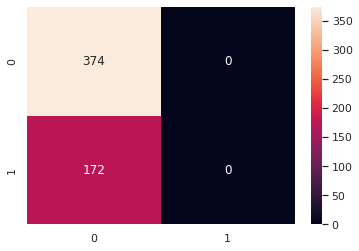

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


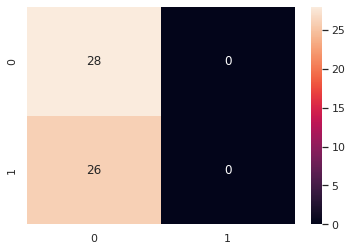

Regularization:1.8


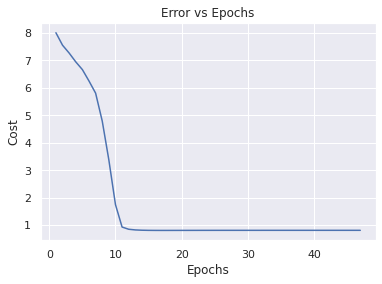

Number of epochs until convergence:47

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


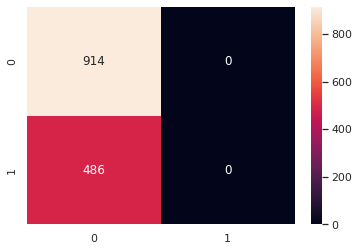

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


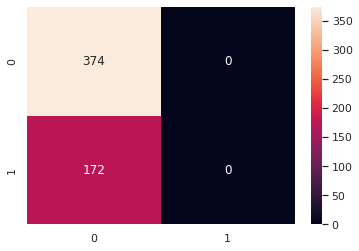

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


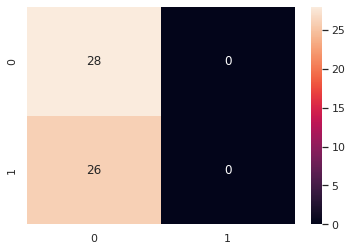

Regularization:1.9000000000000001


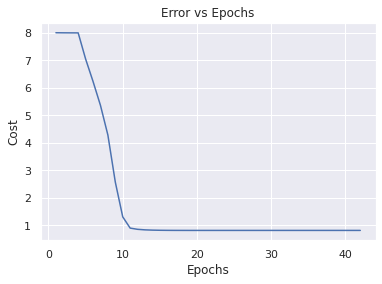

Number of epochs until convergence:42

Training Accuracy
The accuracy is: 65.28571428571428%
Confusion Matrix: 


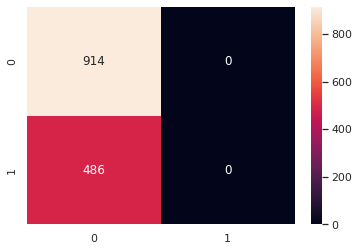

Validation Accuracy
The accuracy is: 68.4981684981685%
Confusion Matrix: 


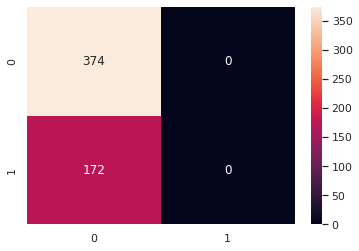

Test Accuracy
The accuracy is: 51.85185185185185%
Confusion Matrix: 


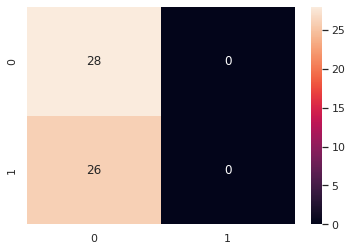

+---------------------+-----------------+-------------------+---------------------+------------------+
|    Regularization   | Epochs to train | Training Accuracy | Validation Accuracy | Testing Accuracy |
+---------------------+-----------------+-------------------+---------------------+------------------+
|         0.0         |       1000      |       77.36       |        78.21        |      77.78       |
|         0.1         |       499       |       74.71       |        75.27        |      72.22       |
|         0.2         |       404       |       65.29       |         68.5        |      51.85       |
| 0.30000000000000004 |       771       |       65.29       |         68.5        |      51.85       |
|         0.4         |       342       |       65.29       |         68.5        |      51.85       |
|         0.5         |       155       |       65.29       |         68.5        |      51.85       |
|  0.6000000000000001 |       129       |       65.29       |         68.

In [38]:
RegResults = PrettyTable(["Regularization","Epochs to train","Training Accuracy","Validation Accuracy","Testing Accuracy"])

for i in range(20):
    print("Regularization:"+str(0.1*i))
    R18Weights, R18Epochs, R18Error, R18Activations = FitNN(trainx,trainy,1,[8],1,["relu","relu"],0.1,0.1*i,1000)
    print("Number of epochs until convergence:"+str(R18Epochs)+"\n")
    print("Training Accuracy")
    R18_Acc=Predict(trainx,trainy,R18Weights,R18Activations)
    print("Validation Accuracy")
    R18_Acc_Val=Predict(validationx,validationy,R18Weights,R18Activations)
    print("Test Accuracy")
    R18_Acc_Test=Predict(testx,testy,R18Weights,R18Activations)
    RegResults.add_row([0.1*i,R18Epochs,np.round(R18_Acc*100,2),np.round(R18_Acc_Val*100,2),np.round(R18_Acc_Test*100,2)])


print(RegResults)

The implementation of regularization seems to have had a negative effect on the accuracy of the network. When the regularization is set to 0, the network performs the best.